In [16]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import models.road_network.create_graph as cg 
import simulation.simulate_routes as sr 
import models.vehicle_models.battery_deg as bd 
import os

from pprint import pprint

In [9]:
with open('routes_study.json', 'r') as f:
    routes = json.load(f)

In [10]:
with open("models/vehicle_models/static_data.json", "r") as file:
    static_data = json.load(file)
with open("models/vehicle_models/vehicle_data.json", "r") as file:
    vehicle_data = json.load(file)
with open("models/vehicle_models/battery_data.json", "r") as file:
    battery_data = json.load(file)

road_network_file = './data_collection/data/large_net/large_edge_data.csv' 
road_df = pd.read_csv(road_network_file)

In [11]:
OCV = battery_data["OCV"]
capacity = battery_data["Capacity"]
R_int = battery_data["R_internal"]
motor_eff = vehicle_data["motor_eff"]

graph = cg.create_osmnx_compatible_graph(road_network_file, debug = False)

In [13]:
def collect_route_data(route, map_data):
    route_output = sr.find_spec_route(route, map_data, graph)
    total_distance, total_consumption, total_climb, detailed_results, current_list, climbs, distances, consumptions = sr.return_route_data_complex(route_output, vehicle_data, static_data,motor_eff, battery_data) 
    return total_consumption, current_list, consumptions,  detailed_results

In [14]:
def analyse_route(route, map_data):
    total_consumption, current_list, consumptions,  detailed_results = collect_route_data(route, map_data)
    capacity_loss = bd.route_analysis(detailed_results, current_list, consumptions,OCV, capacity)
    return(total_consumption, capacity_loss)

In [23]:
def get_route_analysis_results():
    """
    Analyzes routes with different map data types from multiple JSON files with 
    varying multipliers and returns organized results.
    
    Returns:
        dict: Dictionary containing consumption and capacity loss lists for each map type
    """
    # Initialize results dictionary
    results = {}
    
    # Load all map files from the sensitivity_nets directory
    map_files = []
    map_dir = "./data_collection/data/sensitivity_nets"
    
    # Get all JSON files and sort them by index
    for filename in sorted(os.listdir(map_dir), key=lambda x: int(x.split("_")[-1].split(".")[0]) if x.endswith(".json") else 0):
        if filename.endswith(".json"):
            # Extract index from filename (map_data_multiplier_0.json, map_data_multiplier_1.json, etc.)
            index = int(filename.split("_")[-1].split(".")[0])
            multiplier = index * 0.1  # Convert index to actual multiplier
            file_path = os.path.join(map_dir, filename)
            
            # Load the map data
            with open(file_path, 'r') as f:
                map_data = json.load(f)
            
            # Create a descriptive name for this map type
            map_type = f"map_{multiplier:.1f}"  # Using the actual multiplier value, not the index
            
            map_files.append((map_type, map_data))
            
            # Initialize lists for this map type
            results[f"{map_type}_consumptions"] = []
            results[f"{map_type}_capacity_losses"] = []
    
    # Process all routes for each map type
    for route in routes[:100]:  # Adjust the number of routes as needed
        for map_type, map_data in map_files:
            consumption, capacity_loss = analyse_route(route, map_data)
            results[f"{map_type}_consumptions"].append(consumption)
            results[f"{map_type}_capacity_losses"].append(capacity_loss)
    
    return results

In [24]:
sensitivity_results = get_route_analysis_results()


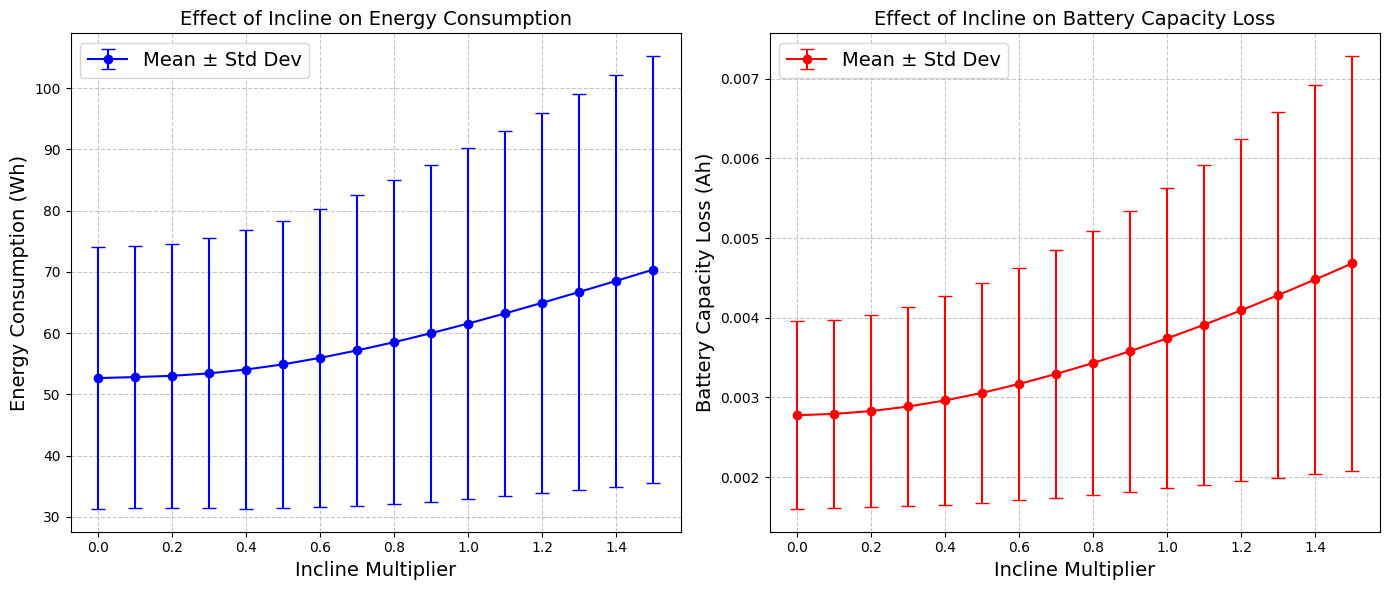

Analysis complete. Results saved to 'incline_sensitivity_results.csv'
Visualizations saved to 'incline_sensitivity_analysis.png'
    Incline Multiplier  Avg Consumption  Std Consumption  Avg Capacity Loss  \
0                  0.0        52.674055        21.390762           0.002777   
1                  0.1        52.833130        21.356083           0.002794   
2                  0.2        53.039487        21.581661           0.002829   
3                  0.3        53.442380        22.058480           0.002886   
4                  0.4        54.070735        22.708214           0.002963   
5                  0.5        54.915311        23.472160           0.003059   
6                  0.6        55.975119        24.362145           0.003170   
7                  0.7        57.195680        25.350524           0.003296   
8                  0.8        58.536865        26.414543           0.003433   
9                  0.9        60.010079        27.508173           0.003582   
10

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_sensitivity_analysis(results):
    """
    Creates visualizations showing how incline affects consumption and capacity loss.
    
    Args:
        results (dict): Dictionary with consumption and capacity loss lists for each map type
    """
    # Extract multipliers and prepare data
    multipliers = []
    avg_consumptions = []
    avg_capacity_losses = []
    std_consumptions = []
    std_capacity_losses = []
    
    # Process results dictionary
    for key in sorted([k for k in results.keys() if k.endswith('_consumptions')]):
        # Extract multiplier from key (map_0.0_consumptions -> 0.0)
        multiplier = float(key.split('_')[1])
        map_type = f"map_{multiplier}"
        
        # Get consumption and capacity loss data
        consumptions = results[f"{map_type}_consumptions"]
        capacity_losses = results[f"{map_type}_capacity_losses"]
        
        # Calculate statistics
        multipliers.append(multiplier)
        avg_consumptions.append(np.mean(consumptions))
        avg_capacity_losses.append(np.mean(capacity_losses))
        std_consumptions.append(np.std(consumptions))
        std_capacity_losses.append(np.std(capacity_losses))
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Consumption vs Incline Multiplier
    ax1.errorbar(multipliers, avg_consumptions, yerr=std_consumptions, 
                 fmt='o-', capsize=5, color='blue', label='Mean ± Std Dev')
    ax1.set_xlabel('Incline Multiplier', fontsize = 14)
    ax1.set_ylabel('Energy Consumption (Wh)', fontsize = 14)
    ax1.set_title('Effect of Incline on Energy Consumption', fontsize = 14)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Plot 2: Capacity Loss vs Incline Multiplier
    ax2.errorbar(multipliers, avg_capacity_losses, yerr=std_capacity_losses, 
                 fmt='o-', capsize=5, color='red', label='Mean ± Std Dev')
    ax2.set_xlabel('Incline Multiplier', fontsize = 14)
    ax2.set_ylabel('Battery Capacity Loss (Ah)', fontsize = 14)
    ax2.set_title('Effect of Incline on Battery Capacity Loss', fontsize = 14)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Add legends
    ax1.legend(fontsize = 14)
    ax2.legend(fontsize = 14)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    plt.savefig('incline_sensitivity_analysis.png', dpi=300)
    
    # Show the plot
    plt.show()
    
    # Create table of numerical results
    results_df = pd.DataFrame({
        'Incline Multiplier': multipliers,
        'Avg Consumption': avg_consumptions,
        'Std Consumption': std_consumptions,
        'Avg Capacity Loss': avg_capacity_losses,
        'Std Capacity Loss': std_capacity_losses
    })
    
    # Save to CSV
    results_df.to_csv('incline_sensitivity_results.csv', index=False)
    
    print(f"Analysis complete. Results saved to 'incline_sensitivity_results.csv'")
    print(f"Visualizations saved to 'incline_sensitivity_analysis.png'")
    
    return results_df

# Example usage
if __name__ == "__main__":
    # Assuming 'results' contains your data
    # results = get_route_analysis_results()
    
    # Create the plots
    results_table = plot_sensitivity_analysis(sensitivity_results)
    print(results_table)

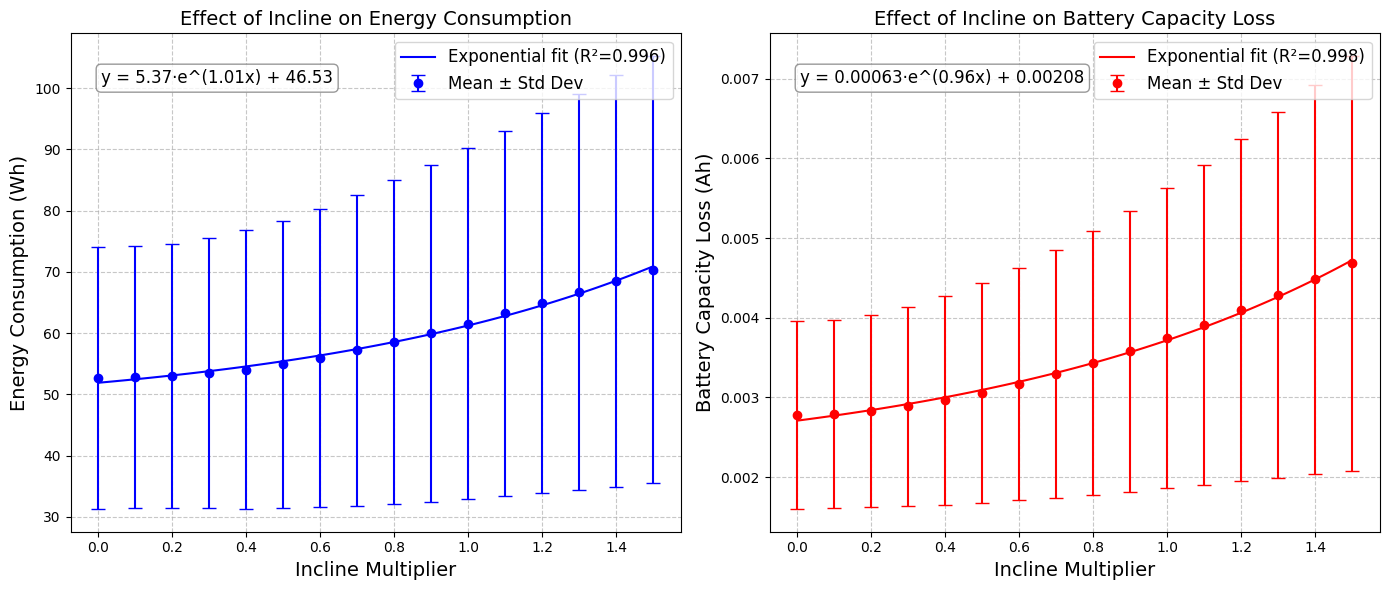


=== Quantitative Analysis of Incline Effects ===
Energy Consumption:
  - Exponential model: y = 5.3749 * e^(1.0081x) + 46.5328
  - R² value: 0.9955
  - Total increase: 33.6% from 52.7 to 70.4 Wh

Battery Capacity Loss:
  - Exponential model: y = 0.000629 * e^(0.9576x) + 0.002080
  - R² value: 0.9976
  - Total increase: 68.6% from 0.002777 to 0.004683 Ah

Implications for Route Optimization:
  - Steep inclines (multiplier > 0.8) show accelerating growth in both metrics
  - Battery capacity loss increases more dramatically (percentage-wise) than energy consumption
  - Route optimization should more heavily penalize steep inclines to maximize battery longevity

Analysis complete. Results saved to 'incline_sensitivity_results.csv'
Visualizations saved to 'incline_sensitivity_analysis.png'
    Incline Multiplier  Avg Consumption  Std Consumption  Avg Capacity Loss  \
0                  0.0        52.674055        21.390762           0.002777   
1                  0.1        52.833130      

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def plot_sensitivity_analysis(results):
    """
    Creates visualizations showing how incline affects consumption and capacity loss,
    with quantitative analysis of the exponential relationship.
    
    Args:
        results (dict): Dictionary with consumption and capacity loss lists for each map type
        
    Returns:
        pd.DataFrame: Results table with statistics and model parameters
    """
    # Extract multipliers and prepare data
    multipliers = []
    avg_consumptions = []
    avg_capacity_losses = []
    std_consumptions = []
    std_capacity_losses = []
    
    # Process results dictionary
    for key in sorted([k for k in results.keys() if k.endswith('_consumptions')]):
        # Extract multiplier from key (map_0.0_consumptions -> 0.0)
        multiplier = float(key.split('_')[1])
        map_type = f"map_{multiplier}"
        
        # Get consumption and capacity loss data
        consumptions = results[f"{map_type}_consumptions"]
        capacity_losses = results[f"{map_type}_capacity_losses"]
        
        # Calculate statistics
        multipliers.append(multiplier)
        avg_consumptions.append(np.mean(consumptions))
        avg_capacity_losses.append(np.mean(capacity_losses))
        std_consumptions.append(np.std(consumptions))
        std_capacity_losses.append(np.std(capacity_losses))
    
    # Define exponential function for curve fitting
    def exp_func(x, a, b, c):
        return a * np.exp(b * x) + c
    
    # Fit exponential curves
    consumption_params, consumption_cov = curve_fit(exp_func, multipliers, avg_consumptions)
    capacity_params, capacity_cov = curve_fit(exp_func, multipliers, avg_capacity_losses)
    
    # Generate fitted values for plotting
    multipliers_fine = np.linspace(min(multipliers), max(multipliers), 100)
    consumption_fit = exp_func(multipliers_fine, *consumption_params)
    capacity_fit = exp_func(multipliers_fine, *capacity_params)
    
    # Calculate R-squared values
    def r_squared(y_true, y_pred):
        ss_total = np.sum((y_true - np.mean(y_true))**2)
        ss_residual = np.sum((y_true - y_pred)**2)
        return 1 - (ss_residual / ss_total)
    
    # Calculate R² for both models
    consumption_fitted = exp_func(np.array(multipliers), *consumption_params)
    capacity_fitted = exp_func(np.array(multipliers), *capacity_params)
    consumption_r2 = r_squared(avg_consumptions, consumption_fitted)
    capacity_r2 = r_squared(avg_capacity_losses, capacity_fitted)
    
    # Calculate percentage increases
    consumption_increase = ((avg_consumptions[-1] - avg_consumptions[0]) / avg_consumptions[0]) * 100
    capacity_increase = ((avg_capacity_losses[-1] - avg_capacity_losses[0]) / avg_capacity_losses[0]) * 100
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Consumption vs Incline Multiplier
    ax1.errorbar(multipliers, avg_consumptions, yerr=std_consumptions, 
                 fmt='o', capsize=5, color='blue', label='Mean ± Std Dev')
    ax1.plot(multipliers_fine, consumption_fit, 'b-', label=f'Exponential fit (R²={consumption_r2:.3f})')
    ax1.set_xlabel('Incline Multiplier', fontsize=14)
    ax1.set_ylabel('Energy Consumption (Wh)', fontsize=14)
    ax1.set_title('Effect of Incline on Energy Consumption', fontsize=14)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(fontsize=12, loc='upper right')
    
    # Add equation to first plot
    eq_text = f"y = {consumption_params[0]:.2f}·e^({consumption_params[1]:.2f}x) + {consumption_params[2]:.2f}"
    ax1.annotate(eq_text, xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12, 
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    # Plot 2: Capacity Loss vs Incline Multiplier
    ax2.errorbar(multipliers, avg_capacity_losses, yerr=std_capacity_losses, 
                 fmt='o', capsize=5, color='red', label='Mean ± Std Dev')
    ax2.plot(multipliers_fine, capacity_fit, 'r-', label=f'Exponential fit (R²={capacity_r2:.3f})')
    ax2.set_xlabel('Incline Multiplier', fontsize=14)
    ax2.set_ylabel('Battery Capacity Loss (Ah)', fontsize=14)
    ax2.set_title('Effect of Incline on Battery Capacity Loss', fontsize=14)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend(fontsize=12, loc='upper right')
    
    # Add equation to second plot
    eq_text = f"y = {capacity_params[0]:.5f}·e^({capacity_params[1]:.2f}x) + {capacity_params[2]:.5f}"
    ax2.annotate(eq_text, xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12, 
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    plt.savefig('incline_sensitivity_analysis.png', dpi=300)
    
    # Show the plot
    plt.show()
    
    # Create table of numerical results with additional analysis
    results_df = pd.DataFrame({
        'Incline Multiplier': multipliers,
        'Avg Consumption': avg_consumptions,
        'Std Consumption': std_consumptions,
        'Avg Capacity Loss': avg_capacity_losses,
        'Std Capacity Loss': std_capacity_losses
    })
    
    # Print analysis results
    print("\n=== Quantitative Analysis of Incline Effects ===")
    print(f"Energy Consumption:")
    print(f"  - Exponential model: y = {consumption_params[0]:.4f} * e^({consumption_params[1]:.4f}x) + {consumption_params[2]:.4f}")
    print(f"  - R² value: {consumption_r2:.4f}")
    print(f"  - Total increase: {consumption_increase:.1f}% from {avg_consumptions[0]:.1f} to {avg_consumptions[-1]:.1f} Wh")
    
    print(f"\nBattery Capacity Loss:")
    print(f"  - Exponential model: y = {capacity_params[0]:.6f} * e^({capacity_params[1]:.4f}x) + {capacity_params[2]:.6f}")
    print(f"  - R² value: {capacity_r2:.4f}")
    print(f"  - Total increase: {capacity_increase:.1f}% from {avg_capacity_losses[0]:.6f} to {avg_capacity_losses[-1]:.6f} Ah")
    
    print("\nImplications for Route Optimization:")
    print("  - Steep inclines (multiplier > 0.8) show accelerating growth in both metrics")
    print("  - Battery capacity loss increases more dramatically (percentage-wise) than energy consumption")
    print("  - Route optimization should more heavily penalize steep inclines to maximize battery longevity")
    
    # Save to CSV
    results_df.to_csv('incline_sensitivity_results.csv', index=False)
    
    print(f"\nAnalysis complete. Results saved to 'incline_sensitivity_results.csv'")
    print(f"Visualizations saved to 'incline_sensitivity_analysis.png'")
    
    return results_df

# Example usage
if __name__ == "__main__":
    # Assuming 'results' contains your data
    # results = get_route_analysis_results()
    
    # Create the plots
    results_table = plot_sensitivity_analysis(sensitivity_results)
    print(results_table)